In [143]:
import pandas as pd
import numpy as np
import string
import random

from sklearn.exceptions import ConvergenceWarning
from sklearn.neural_network import MLPClassifier
from typing import Literal
from tqdm import tqdm

import warnings
warnings.simplefilter(action='ignore', category=RuntimeWarning)
warnings.simplefilter(action='ignore', category=ConvergenceWarning)

__name__ = 'ah'

In [144]:
trains = pd.read_csv(r"./DataSets/train/alphabet_dataset.txt", header= None)

tests_10 = pd.read_csv(r"./DataSets/test/letter10error.txt", header= None)
tests_15 = pd.read_csv(r"./DataSets/test/letter15error.txt", header= None)
tests_20 = pd.read_csv(r"./DataSets/test/letter20error.txt", header= None)


In [145]:
trains.head()

,0,1,2,3,4,5,6,7,8,9,...,54,55,56,57,58,59,60,61,62,63
0,-1,-1,1,1,-1,-1,-1,-1,-1,-1,...,1,-1,1,1,1,-1,1,1,1,A
1,-1,-1,-1,1,-1,-1,-1,-1,-1,-1,...,1,-1,-1,1,-1,-1,-1,1,-1,A
2,-1,-1,-1,1,-1,-1,-1,-1,-1,-1,...,-1,1,1,1,-1,-1,-1,1,1,A
3,1,1,1,1,1,1,-1,-1,1,-1,...,-1,1,1,1,1,1,1,1,-1,B
4,1,1,1,1,1,1,-1,1,-1,-1,...,-1,1,1,1,1,1,1,1,-1,B


In [146]:
letters = list(string.ascii_uppercase)
outputs = {key: val for key, val in zip(letters, range(len(letters)))}
trains[63] = trains[63].map(outputs)
tests_10[63] = tests_10[63].map(outputs)
tests_15[63] = tests_15[63].map(outputs)
tests_20[63] = tests_20[63].map(outputs)
#########################################


In [147]:
X_train = trains.drop(63, axis= 1).to_numpy()
X_10 = tests_10.drop(63, axis= 1).to_numpy()
X_15 = tests_15.drop(63, axis= 1).to_numpy()
X_20 = tests_20.drop(63, axis= 1).to_numpy()
################################
Y_train = trains[63].to_numpy()
Y_train = Y_train.tolist()

Y_10 = tests_10[63].to_numpy()
Y_10 = Y_10.tolist()

Y_15 = tests_15[63].to_numpy()
Y_15 = Y_15.tolist()

Y_20 = tests_20[63].to_numpy()
Y_20 = Y_20.tolist()


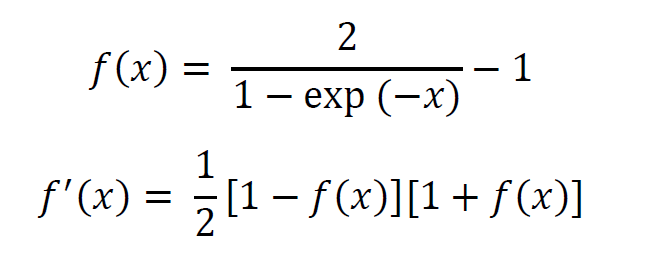

In [148]:
class customError(Exception):
    pass

In [149]:
class Matrix:
    def __init__(self, rows, cols, data):
        self.rows = rows
        self.cols = cols
        self.data = data
    def __str__(self) -> str:
        return f"{str(self.data)}"
    def __repr__(self) -> str:
        return f"{repr(self.data)}"
    def __getitem__(self, index):
        return self.data[index]
    @classmethod
    def zeros(cls, rows, cols):
        data = [[0.0] * cols for _ in range(rows)]
        return cls(rows, cols, data)

    @classmethod
    def random(cls, rows, cols):
        data = cls.zeros(rows, cols)
        for i in range(len(data.data)):
            for j in range(len(data.data[i])):
                data.data[i][j] = random.uniform(-1, 1)
        return cls(rows, cols, data)

    @classmethod
    def from_data(cls, data):
        rows = len(data)
        cols = len(data[0])
        for row in range(1, rows):
            if len(data[row - 0]) != len(data[row]): 
                raise ValueError(f"All rows must have the same number of columns dif in {data[row - 0]},{data[row]}")
        return cls(rows, cols, data)

    def multiply(self, other):
        if not isinstance(other, Matrix):
            other = Matrix.from_data(other)
        if self.cols != other.rows:
            raise ValueError(f"Attempted to multiply by matrix of incorrect dimensions self=({self.rows},{other.rows}) other=({self.cols},{other.cols})")

        res_data = [[0.0] * other.cols for _ in range(self.rows)]

        for i in range(self.rows):
            for j in range(other.cols):
                sum_val = sum(self.data[i][k] * other.data[k][j] for k in range(self.cols))
                res_data[i][j] = sum_val

        return Matrix(self.rows, other.cols, res_data)

    def add(self, other):
        if self.rows != other.rows or self.cols != other.cols:
            raise ValueError(f"Attempted to add matrix of incorrect dimensions; self=({self.rows},{other.rows}) other=({self.cols},{other.cols})")

        res_data = [[self.data[i][j] + other.data[i][j] for j in range(self.cols)] for i in range(self.rows)]

        return Matrix(self.rows, self.cols, res_data)

    def dot_multiply(self, other):
        if self.rows != other.rows or self.cols != other.cols:
            raise ValueError(f"Attempted to dot multiply by matrix of incorrect dimensions; self=({self.rows},{other.rows}) other=({self.cols},{other.cols})")

        res_data = [[self.data[i][j] * other.data[i][j] for j in range(self.cols)] for i in range(self.rows)]

        return Matrix(self.rows, self.cols, res_data)

    def subtract(self, other):
        if self.rows != other.rows or self.cols != other.cols:
            raise ValueError(f"Attempted to subtract matrix of incorrect dimensions; self=({self.rows},{other.rows}) other=({self.cols},{other.cols})")

        res_data = [[self.data[i][j] - other.data[i][j] for j in range(self.cols)] for i in range(self.rows)]

        return Matrix(self.rows, self.cols, res_data)
    
    def map(self, function):
        res_data = [[function(value) for value in row] for row in self.data]
        return Matrix(self.rows, self.cols, res_data)

    def transpose(self):
        res_data = np.array(self.data).transpose().tolist()
        # res_data = [[self.data[j][i] for j in range(self.cols)] for i in range(self.rows)]
        return Matrix(self.cols, self.rows, res_data)
    def __len__(self):
        return len(self.data)
    def tolist(self):
        return self.data

In [150]:
class Actiovation:
    def __init__(self, func : callable, derivative: callable) -> None:
        self.func : callable = func
        self.derivative : callable = derivative
    def __str__(self) -> str:
        return f"function   = {str(self.func)},\nderivation = {str(self.derivative)}"
    def __repr__(self) -> str:
        return f"{self.__str__()}"


def Bipolar_sigmoid_function(x):
    """Bipolar sigmoid function"""
    if x >= 0:
        return (1 / (1 + np.exp(-2 * x))) - 0.5
    else:
        return -(1 / (1 + np.exp(2 * x))) - 0.5

def Bipolar_sigmoid_derivative(x):
    """Derivative of the bipolar sigmoid function"""
    if x >= 0:
        return 4 * x * ((np.exp(-2 * x))/(1 + np.exp(-2 * x)))**2
    else:
        return -4 * x * ((np.exp(2 * x))/(1 + np.exp(2 * x)))**2


def Sigmoid_function(x):
    """Sigmoid function"""
    return 1 / (1 + np.exp(-x))

def Sigmoid_derivative(x):
    """Derivative of the sigmoid function"""
    return Sigmoid_function(x)*(1-Sigmoid_function(x))

def Relu_function(x):
    """ReLU activation function"""
    return max(0,x)

def Relu_derivative(x):
    """Derivative of the ReLU activation function"""
    if x > 0:
        return 1
    elif x <= 0:
        return 0
    
def Tanh_function(x):
    """Tanh activation function"""
    return np.tanh(x)
def Tanh_derivative(x):
    """Derivative of the tanh activation function"""
    return 1-(np.tanh(x))**2

def Softmax_function(x):
    """Softmax activation function"""
    e_x = np.exp(x - np.max(x)) 
    return e_x/e_x.sum()

def Softmax_derivative(x):
    """Derivative of softmax activation function"""
    return Softmax_function(x)*(1-Softmax_function(x))

def Linear_function(x):
    """Linear activation function"""
    return x
def Linear_derivative(x):
    """Derivative of linear activation function"""
    return 1



# Activations functions and their derivatives
relu_activator: Actiovation = Actiovation(
                                        func = Relu_function,
                                        derivative = Relu_derivative)
sigmode_activator: Actiovation = Actiovation(
                                        func   =  Sigmoid_function ,
                                        derivative =  Sigmoid_derivative )
Bipolar_sigmoid_activator : Actiovation = Actiovation(
                                        func = Bipolar_sigmoid_function,
                                        derivative = Bipolar_sigmoid_derivative)
linear_activator : Actiovation = Actiovation(
                                        func = Linear_function,
                                        derivative = Linear_derivative)
softmax_activator : Actiovation = Actiovation(
                                        func = Softmax_function,
                                        derivative = Softmax_derivative)
tanh_activator : Actiovation = Actiovation(
                                        func = Tanh_function,
                                        derivative = Tanh_derivative)



In [159]:
class MLPNetWork:
    def __type__(self):
        return "NLP"
    def __init__(self, 
                 layers : tuple[int] = (100,), 
                 lr : float = 0.00001, 
                 max_iter : int = 200,
                 activation: Literal["bisig", "sigmoide", 
                                     "relu", 'tanh', 'softmax'] = "bisig" , 
                 ) -> None:
        if isinstance(layers, tuple):
            layers = list(layers)
        if 0. > lr > 1.:
            raise ValueError("Learning rate must be between 0 and 1")

        if not (isinstance(layers, tuple) or isinstance(layers, list)):
            raise TypeError("layers input should be a tuple/list of Integers")
 
        self.lr : float = lr
        self.layers : tuple[int,] = layers
        self.activation = activation
        self.max_iter : int = max_iter

        self.history = {"error" : []}

        match self.activation:
            case "bisig":
                self.activation_function = Bipolar_sigmoid_activator 
            case "sigmoide":
                self.activation_function = sigmode_activator
            case "relu":
                self.activation_function = relu_activator
            case "tanh":
                self.activation_function = tanh_activator
            case "softmax":
                self.activation_function = softmax_activator
            case _:
                raise ValueError('Invalid activation Function')
            
    def __str__(self) -> str:
        return f"MLPNetWork(lr = {self.lr}, hidden_layers = {tuple(self.layers)},  iteration= {self.max_iter}, activator={str(self.activation)} "
    def __repr__(self) -> str:
        return f"{self.__str__()}"
    
    def _build_weights_and_bias(self, layers):
        weights = list()
        bias = list()
        # [63, 10, 26]
        for i in range(len(layers) - 1 ):
            weights.append(Matrix.random( rows= layers[i + 1], cols=  layers[i] )  )
            bias.append(Matrix.random(rows= layers[i + 1], cols= 1 )  )

        return weights, bias

    def _feed_forward(self, inputs: list):
        if len(inputs) != self.layers[0]:
            raise customError("Invalid inputs length")
        if not isinstance(inputs, list):
            inputs = list(inputs)

        current = Matrix.from_data([inputs]).transpose()
        self.data = [current]
        for layer in range(len(self.layers) -1):
            # print(self.layers)
            current = self.weights[layer].\
                    multiply(current).\
                    add(self.bias[layer]).\
                    map(self.activation_function.func)
            
            self.data.append(current)

        return current.transpose().data[0]
        
        
    def _back_propogate(self, outputs, targets):
        if len(targets) != self.layers[len(self.layers) - 1 ]:
            raise customError("Invalid targets length")

        paresd  = Matrix.from_data([outputs]).transpose()
        err = Matrix.from_data([targets])\
                                .transpose()\
                                    .subtract(paresd)
        
        gradient = paresd.map(self.activation_function.derivative)

        for i in reversed(range(len(self.layers) - 1)):
            # print(i)
            gradient = gradient.dot_multiply(err).\
                map(lambda x : x * self.lr)
            
            self.weights[i] = self.weights[i].\
                add (gradient.\
                     multiply( self.data[i].transpose() ) )
            
            self.bias[i] = self.bias[i] .add(gradient)

            err = self.weights[i].transpose().multiply (err)
            gradient =  self.data[i].map(self.activation_function.derivative)

        return err.data
        

    def fit(self, inputs, targets : list):
        """Train the model with given data and target values"""
        s = len(set(targets ))
        perfect_layer = self.layers
        perfect_layer.insert(0, len(inputs[0]))
        perfect_layer.append(s)
        
        self.weights , self.bias = self._build_weights_and_bias(perfect_layer)

        target = [ [0.] * s for _ in range(len(targets)) ]
 
        for index, value in enumerate(target):
            value[int(targets[index])] = 1.

        errors = []
        for iter in tqdm(range(self.max_iter)):
            for j in range(len(inputs)):
                out = self._feed_forward(inputs[j])
                err = self._back_propogate(out, target[j])
                errors.append(err[0])
                # Adaptive Learning rate
                self.lr =  self.lr * (1 - .2 * iter)


        self.history = dict()
        self.history["error" ] =  np.array(errors).reshape(-1).tolist()
        return self          

    def predict(self, inputs):
        res = list()
        
        try:
            len(inputs[0])
            for i in inputs:
                outputs = self._feed_forward(i)
                
                res.append(np.array(outputs).tolist())
            
            # print("Res outputs ", outputs)
            # print(res)
            predicted = [ np.argmax(idx  ) for idx in res]
            # print(predicted)
            return predicted
        except:
            output = self._feed_forward(inputs)
            # print("output ",output)

            predicted = [ np.argmax(idx  ) for idx in output]
            # print(predicted)
            return predicted

    def evaluate(self, x_test, y_test):
        y_hat = np.array(self.predict(x_test))
        y_test = np.array(y_test)

        correct_predictions = np.sum(y_hat == y_test)
        total_samples = len(y_test)
        
        accuracy = correct_predictions / total_samples
        return accuracy
                                   


In [160]:
# 10 , 15 , 20, 25, 30
Hidden_Layer : tuple[int,] = ( 100, )
# print(type(Hidden_Layer))
# .1 , .2 , .3 , .4 , .5 , .6 , .7 , .8 , .9
learning_rate : float = .1
# 100 , 200 , 300 , 400 , 500 , 600 , 700 , 800 , 900 , 1000
iteration : int = 10
active_function : Literal['bisig', 'sigmoide', 'relu', 'tanh', 'softmax'] = 'sigmoide'

my_model = MLPNetWork(layers= Hidden_Layer,
                      lr = learning_rate,
                      max_iter = iteration,
                      activation = active_function)

my_model_history = my_model.fit(X_train ,Y_train)


sklearn_model = MLPClassifier(hidden_layer_sizes= Hidden_Layer,
                              activation = 'logistic',
                              alpha= learning_rate,
                              max_iter= iteration)

sklearn_model_history = sklearn_model.fit(X_train, Y_train)

print("-"*21)
print(my_model_history)
print(sklearn_model_history)

100%|██████████| 10/10 [00:14<00:00,  1.46s/it]

[[[-8.740036848747991], [-4.370946360534556], [34.51136649958232], [12.310412164621184], [-23.409370340070616], [12.22145224522751], [-10.04463760098233], [-11.17143747344745], [-4.347213489344597], [-9.880929903351408], [-13.100536295918555], [-13.360858208941247], [-5.886542762924762], [-18.611899783008187], [-12.598594019198169], [-19.9873969214757], [7.974913888323687], [28.67332825008285], [-13.072913215621469], [-2.6296295004960033], [1.8199842751140856], [1.3308205110197453], [-0.8522289704982995], [7.951679953576444], [-13.58469035949795], [5.236794413856572], [-17.00510367402335], [-10.876336571317543], [-9.360034499517013], [16.590419665726447], [2.352061864519527], [-2.687426056308497], [-2.2233203900793947], [-22.16158232767137], [-30.20211774789473], [-18.285240051122635], [-6.399288746324597], [18.975374820056604], [2.268996751955754], [10.964843678898745], [5.96136759421301], [-19.707932904909942], [-12.36829577469811], [0.3020542429908708], [3.4693327392355098], [-0.251

In [161]:
print(my_model_history.lr)
my_model_history.history['error']

0.0


[-8.740036848747991,
 -4.370946360534556,
 34.51136649958232,
 12.310412164621184,
 -23.409370340070616,
 12.22145224522751,
 -10.04463760098233,
 -11.17143747344745,
 -4.347213489344597,
 -9.880929903351408,
 -13.100536295918555,
 -13.360858208941247,
 -5.886542762924762,
 -18.611899783008187,
 -12.598594019198169,
 -19.9873969214757,
 7.974913888323687,
 28.67332825008285,
 -13.072913215621469,
 -2.6296295004960033,
 1.8199842751140856,
 1.3308205110197453,
 -0.8522289704982995,
 7.951679953576444,
 -13.58469035949795,
 5.236794413856572,
 -17.00510367402335,
 -10.876336571317543,
 -9.360034499517013,
 16.590419665726447,
 2.352061864519527,
 -2.687426056308497,
 -2.2233203900793947,
 -22.16158232767137,
 -30.20211774789473,
 -18.285240051122635,
 -6.399288746324597,
 18.975374820056604,
 2.268996751955754,
 10.964843678898745,
 5.96136759421301,
 -19.707932904909942,
 -12.36829577469811,
 0.3020542429908708,
 3.4693327392355098,
 -0.2514075089186878,
 4.061335612173574,
 8.464961312

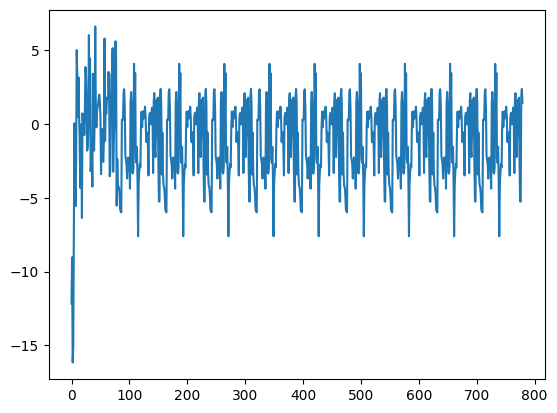

In [154]:
from matplotlib import pyplot as plt


plt.plot(my_model_history.history['error'])
plt.show()

In [155]:
# My Model
my_eval_10 =  my_model.evaluate(X_10, Y_10)
my_eval_15 =  my_model.evaluate(X_15, Y_15)
my_eval_20 =  my_model.evaluate(X_20, Y_20)
# Sklearn Model
sklearn_eval_10 =  sklearn_model.score(X_10, Y_10)
sklearn_eval_15 =  sklearn_model.score(X_15, Y_15)
sklearn_eval_20 =  sklearn_model.score(X_20, Y_20)

# print Results of evals
print("My Model Evaluation on X_10: " , round(my_eval_10, 2)  )
print("My Model Evaluation on X_15: " , round(my_eval_15, 2)  )
print("My Model Evaluation on X_20: " , round(my_eval_20, 2)  )
#################################
print("=" *34)
#################################
print("Sklearn Evaluation on X_10:  " , round(sklearn_eval_10, 2) )
print("Sklearn Evaluation on X_15:  " , round(sklearn_eval_15, 2) )
print("Sklearn Evaluation on X_20:  " , round(sklearn_eval_20, 2) )

My Model Evaluation on X_10:  0.23
My Model Evaluation on X_15:  0.27
My Model Evaluation on X_20:  0.23
Sklearn Evaluation on X_10:   0.15
Sklearn Evaluation on X_15:   0.23
Sklearn Evaluation on X_20:   0.15


In [156]:
sklearn_model_history

MLPClassifier(activation='logistic', alpha=0.1, max_iter=10)

In [157]:
print(f"My prediction on X_10 :     {my_model.predict(X_10)}")
print(f"The true value of Y_10 is:  {Y_10}")
print("_" *34)

print(f"My prediction on X_10 :     {my_model.predict(X_15)}")
print(f"The true value of Y_10 is:  {Y_15}")
print("_" *34)

print(f"My prediction on X_10 :     {my_model.predict(X_20)}")
print(f"The true value of Y_10 is:  {Y_20}")

My prediction on X_10 :     [0, 20, 24, 16, 25, 25, 20, 22, 25, 25, 22, 11, 25, 25, 14, 13, 16, 11, 15, 25, 21, 25, 18, 16, 24, 25]
The true value of Y_10 is:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25]
__________________________________
My prediction on X_10 :     [25, 16, 24, 23, 25, 13, 16, 25, 25, 9, 25, 11, 25, 7, 14, 13, 16, 16, 18, 25, 6, 16, 18, 23, 0, 25]
The true value of Y_10 is:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25]
__________________________________
My prediction on X_10 :     [0, 22, 11, 23, 18, 25, 10, 25, 25, 25, 11, 4, 25, 0, 16, 15, 16, 18, 24, 9, 6, 25, 18, 23, 24, 25]
The true value of Y_10 is:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25]


In [158]:
print(f"Sklearn prediction on X_10 : {sklearn_model.predict(X_10).tolist()}")
print(f"The true value of Y_10 is:   {Y_10}")
print("_" *34)

print(f"Sklearn prediction on X_10 : {sklearn_model.predict(X_15).tolist()}")
print(f"The true value of Y_10 is:   {Y_15}")
print("_" *34)

print(f"Sklearn prediction on X_10 : {sklearn_model.predict(X_20).tolist()}")
print(f"The true value of Y_10 is:   {Y_20}")

Sklearn prediction on X_10 : [12, 18, 2, 16, 21, 0, 18, 18, 5, 8, 17, 2, 21, 16, 2, 18, 16, 17, 5, 17, 18, 1, 12, 12, 19, 25]
The true value of Y_10 is:   [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25]
__________________________________
Sklearn prediction on X_10 : [12, 18, 2, 2, 17, 18, 18, 7, 24, 19, 16, 16, 2, 17, 2, 18, 16, 17, 18, 19, 2, 1, 17, 12, 19, 24]
The true value of Y_10 is:   [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25]
__________________________________
Sklearn prediction on X_10 : [12, 21, 16, 16, 2, 17, 2, 7, 24, 24, 16, 12, 18, 16, 2, 0, 16, 17, 18, 24, 2, 1, 17, 9, 12, 12]
The true value of Y_10 is:   [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25]
